# Machine Learning 5: Boosting

## Submission by: Mark Preston

This week, I'll be using a census data set to classify individual adults that make above and below 50K in a given year. The set includes a variety of individual traits for a person, including age, race, work details, educational attainment, and family background, to name a few. Since the data set doesn't include a header here, I've manually added it during the data loading using the `names` parameter. The target variable is whether an individual will make above or below 50K in a year, which is just a binary flag I've names income_bracket in the set.

### Data Processing

Beginning the analysis, the main data processing stems from needing to download the data from the UCI Machine Learning Repository. The data should be relatively clean coming from a well known data source but, I did need to add in header names using the set's data dictionary (https://archive.ics.uci.edu/ml/datasets/Adult). With the basic processing, I've loaded the set in and evaluated the shape below.

In [2]:
import pandas as pd

adult_census = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
    header = None, 
    skipinitialspace = True, 
    names = ["age", "work_class", "fnlwgt", "education", "edu_years", "marital_status", 
             "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
             "hours_per_week", "native_country", "income_bracket"]
)

print("The census data has", 
      adult_census.shape[0], "rows and", 
      adult_census.shape[1],  "columns")

The census data has 32561 rows and 15 columns


Working with data from the UCI usually means a clean set. To verify this though, I've counted the null values in the set below. As seen, there are no null values so the set is clean and well maintained.

In [27]:
pd.DataFrame({"is_null_count": adult_census.isnull().sum()})

,is_null_count
age,0
work_class,0
fnlwgt,0
education,0
edu_years,0
marital_status,0
occupation,0
relationship,0
race,0
sex,0


As another small update, I'm also dropping the fnlwgt column as well. With this, there are 14 columns remaining for the modelling work.

In [3]:
adult_census = adult_census.drop(columns=["fnlwgt"])

print("The updated census data has", 
      adult_census.shape[0], "rows and", 
      adult_census.shape[1],  "columns")

The updated census data has 32561 rows and 14 columns


The final formal update to the set is replacing the categorical income bracket labels with numeric values. For this,  $50K \leq$ becomes a zero while over 50K a one. To validate that the replacement worked, I've done a value count for each level in the variable. As seen, the labels are now numeric. The set has about 76% of individuals $50K \leq$ yearly.

In [4]:
adult_census["income_bracket"] = adult_census["income_bracket"].replace(["<=50K", ">50K"], [0, 1])

pd.DataFrame({"income_count": adult_census["income_bracket"].value_counts()})

,income_count
0,24720
1,7841


With the cleaning complete, I've split the data into training and test for the modelling portion. I've elected to use a 70/30 split, which is confirmed by the dimensional prinout from the new sets. As an additional update, I've used dummy coding for the categorical features. This expands the set to 107 columns.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

predictors = adult_census.drop(columns=["income_bracket"], axis=1)

X_encoded = pd.get_dummies(predictors)

outcome = adult_census[["income_bracket"]]

X_train, X_test, y_train, y_test = train_test_split(X_encoded, outcome, random_state=1017, test_size=.3)

print(
"Training set rows:", X_train.shape[0], "which is", 
    np.round(X_train.shape[0] / adult_census.shape[0] * 100), 
    "percent of total records"
)

print(
"Test set rows:", X_test.shape[0], "which is", 
    np.round(X_test.shape[0] / adult_census.shape[0] * 100),
    "percent of total records"
)

print("Training set columns:", X_train.shape[1])
print("Test set columns:", X_test.shape[1])

Training set rows: 22792 which is 70.0 percent of total records
Test set rows: 9769 which is 30.0 percent of total records
Training set columns: 107
Test set columns: 107


In [76]:
y_train.head()

,income_bracket
14561,0
11939,0
29771,1
15006,1
27503,0


### Baseline Random Forest Classifier

The baseline random forest is an okay starting point for getting a better understanding of the prediction task. That said, without any tuning parameters, especially max depth, the model should be very overfit. There's still some value to using it as a starting point though. Below, I've fit the baseline model.

In [140]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=1017)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1017, verbose=0,
            warm_start=False)

The initial few predictions look promising enough. The classifier shows all five records are accurate here.

In [141]:
baseline_rf_preds = pd.DataFrame({
    "actual": y_test["income_bracket"],
    "class_pred": rf.predict(X_test),
    "under_50_prob": rf.predict_proba(X_test)[:,0],
    "over_50_prob": rf.predict_proba(X_test)[:,1]
})

baseline_rf_preds.head()

,actual,class_pred,over_50_prob,under_50_prob
8584,1,1,0.7,0.3
16101,0,0,0.0,1.0
15201,0,0,0.4,0.6
15160,1,1,1.0,0.0
11843,0,0,0.0,1.0


The confusion matrix shows a reasonable first result. I'm not in tune with the business or social research context but, I'm assuming the idea is to have a good balanced accuracy here. The under 50 predictions are more reasonable here but, the true over 50 values still seem good.

In [142]:
import sklearn.metrics as metrics

earnings_cm = pd.DataFrame(confusion_matrix(y_true=y_test["income_bracket"], 
                                           y_pred=baseline_rf_preds["class_pred"]), 
                          columns=pd.Series(["Under 50", "Over 50"], dtype="category"),
                          index=pd.Series(["Under 50", "Over 50"], dtype="category"))

earnings_cm

,Under 50,Over 50
Under 50,6793,635
Over 50,941,1400


the classification report seems to add more depth to the balance argument. Overall, the metrics seem balanced across all classes, though they are better for under 50 predictions.

In [143]:
print(classification_report(y_test["income_bracket"], baseline_rf_preds["class_pred"]))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90      7428
          1       0.69      0.60      0.64      2341

avg / total       0.83      0.84      0.83      9769



The test AUC score is also very impressive showing about .87. Given this is the baseline model, this seems to suggest the tuned models will be able to provide very good predictions.

In [85]:
print("Initial random forest default model AUC:", 
      metrics.roc_auc_score(y_test["income_bracket"], baseline_rf_preds["over_50_prob"]).round(4))

Initial random forest default model AUC: 0.8692


Looking into what might be driving this result, I've included the top 5 variables by importance here. Age appears as the most important. Putting them all together, my intuition is educated, older, and married individuals do better. The capital gains variable feels like it might be slight data leakage given this represents a tax from the sale of specific types of assets, including stocks, bonds, precious metals and real estate. Inherently, an individual needs a reasonable amount of money to make these types of sales so it's not surprising to see it as important for classifyig individuals who would make over 50K.

In [144]:
var_importance =  pd.DataFrame({
    "name": list(X_train.head(0)),
    "var_importance": rf.feature_importances_}) 

var_importance.sort_values(by=["var_importance"], ascending=False).head()

,name,var_importance
0,age,0.235792
4,hours_per_week,0.116604
2,capital_gain,0.099821
32,marital_status_Married-civ-spouse,0.081542
1,edu_years,0.064467


Checking on overfitting, it's not surprising to see such a high model accuracy and AUC. As I mentioned, the default tree setting has no max depth specified so it fits the data nearly perfectly creating the overfit model; that's sort of given with this baseline model. That said, the initial accuracy metrics in test are a reasonable starting point. A tuned model should show some evaluation metric increases.

In [95]:
baseline_rf_train_preds = pd.DataFrame({
    "actual": y_train["income_bracket"],
    "class_pred": rf.predict(X_train),
    "under_50_prob": rf.predict_proba(X_train)[:,0],
    "over_50_prob": rf.predict_proba(X_train)[:,1]
})

print(classification_report(y_train["income_bracket"], baseline_rf_train_preds["class_pred"]))
print("Initial random forest default model training AUC:", 
      metrics.roc_auc_score(y_train["income_bracket"], baseline_rf_train_preds["over_50_prob"]).round(4))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98     17292
          1       0.96      0.91      0.94      5500

avg / total       0.97      0.97      0.97     22792

Initial random forest default model training AUC: 0.9958


### AdaBoost Classifier with Grid Search

With the baseline established, I'll work to develop some more tuned options. Starting this, I've included an AdaBoost model. It's being tuned with a grid search operation using ROC as the evaluation metric. Since I'll be constructing three tuned models with different search methods and parameters, I've developed a function that can accommodate the necessary customization and return the necessary evaluation objects, including reports and confusion matrices.

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

def custom_tune(classifier, search, tune_params):
    grid_search_model = search(classifier, tune_params, cv = 5, 
                               scoring = "roc_auc", refit = True, n_jobs = -1, verbose = 5)
    grid_search_model.fit(X_train, y_train.values.ravel())
    
    #developing predictions using model fit
    grid_search_train_preds = pd.DataFrame({
    "actual": y_train["income_bracket"],
    "class_pred": grid_search_model.best_estimator_.predict(X_train),
    "under_50_prob": grid_search_model.best_estimator_.predict_proba(X_train)[:,0],
    "over_50_prob": grid_search_model.best_estimator_.predict_proba(X_train)[:,1]
    })
    
    grid_search_test_preds = pd.DataFrame({
    "actual": y_test["income_bracket"],
    "class_pred": grid_search_model.best_estimator_.predict(X_test),
    "under_50_prob": grid_search_model.best_estimator_.predict_proba(X_test)[:,0],
    "over_50_prob": grid_search_model.best_estimator_.predict_proba(X_test)[:,1]
    })
    
    #creating confusion matrix for preds
    tuned_train_cm = pd.DataFrame(confusion_matrix(y_true=y_train["income_bracket"], 
                                                           y_pred=grid_search_train_preds["class_pred"]), 
                                          columns=pd.Series(["Under 50", "Over 50"], dtype="category"),
                                          index=pd.Series(["Under 50", "Over 50"], dtype="category"))
    
    tuned_test_cm = pd.DataFrame(confusion_matrix(y_true=y_test["income_bracket"], 
                                                           y_pred=grid_search_test_preds["class_pred"]), 
                                          columns=pd.Series(["Under 50", "Over 50"], dtype="category"),
                                          index=pd.Series(["Under 50", "Over 50"], dtype="category"))
    
    #creating classification reports
    train_class_report = classification_report(y_train["income_bracket"], 
                                               grid_search_train_preds["class_pred"])
    test_class_report = classification_report(y_test["income_bracket"], 
                                              grid_search_test_preds["class_pred"])
    
    #creating auc
    train_auc = metrics.roc_auc_score(y_train["income_bracket"], grid_search_train_preds["over_50_prob"]).round(4)
    test_auc = metrics.roc_auc_score(y_test["income_bracket"], grid_search_test_preds["over_50_prob"]).round(4)
    
    #creating feature importance
    feature_importance = grid_search_model.best_estimator_.feature_importances_
    
    output = {"test_cm": tuned_test_cm,
              "train_cm": tuned_train_cm,
              "test_report": test_class_report,
              "train_report": train_class_report,
              "test_auc": test_auc,
              "train_auc": train_auc,
              "test_results": grid_search_test_preds,
              "feature_importance": feature_importance
              }
    
    print("Best model parameters from Grid Search:")
    print(grid_search_model.best_params_)
    
    
    return(output)

ada=AdaBoostClassifier(random_state=1017)

ada_parameters = {
    "learning_rate": [0.2, 0.4, 0.6, 0.8, 1,  1.2],
    "n_estimators": [100, 200, 300, 400],
    "random_state":[1017]
}

tuned_ada = custom_tune(classifier=ada, search=GridSearchCV, tune_params=ada_parameters)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.5min finished


Best model parameters from Grid Search:
{'learning_rate': 1.2, 'n_estimators': 400, 'random_state': 1017}


the initial test confusion matrix shows a nice upgrade from the baseline random forest. The true negatives were 1400 in that model and have risen to 1509 here highlighting better predictive powers. 

In [34]:
tuned_ada["test_cm"]

,Under 50,Over 50
Under 50,6974,454
Over 50,832,1509


The classification report further bolsters this. The average metrics are each up 3 points from the random forest. This highlights that the tuning, and boosting model, seem to help improve the predictive work.

In [103]:
print(tuned_ada["test_report"])

             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7428
          1       0.77      0.64      0.70      2341

avg / total       0.86      0.87      0.86      9769



As a final evaluation metric, the AdaBoost AUC is about .925, another increase from the original .869 from the random forest.

In [125]:
print("Tuned AdaBoost model test AUC:", tuned_ada["test_auc"])

Tuned AdaBoost model test AUC: 0.9252


The prediction evaluation output for the fitted training values are found below. The results show the model is perhaps slightly overfit but, in general the evaluation metrics between train and test have been greatly reduced. For example, all the classification report average metrics are more or less equal while the AUC is also congruent. While there is still some generalization error gap, the overfitting has been diminished.

In [105]:
tuned_ada["train_cm"]

,Under 50,Over 50
Under 50,16296,996
Over 50,1911,3589


In [107]:
print(tuned_ada["train_report"])

             precision    recall  f1-score   support

          0       0.90      0.94      0.92     17292
          1       0.78      0.65      0.71      5500

avg / total       0.87      0.87      0.87     22792



In [106]:
print("Tuned AdaBoost model train AUC:", tuned_ada["train_auc"])

Tuned AdaBoost model train AUC: 0.9312


The top 5 features here show some similarities with the random forest but, there are some differences. Now, both capital losses and gains are shown as being the top two predictors. Again, I think this makes intuitive sense given they're linked to transactions commonly linked to wealthier people. The other three were still identified by the the random forest, though not in the ranking order. Overall though, there is clear commonality between the model's on feature importance.

In [42]:
tuned_ada_importance = pd.DataFrame({
    "name": list(X_train.head(0)),
    "var_importance": tuned_ada["feature_importance"]
})

tuned_ada_importance.sort_values(by=["var_importance"], ascending=False).head()

,name,var_importance
2,capital_gain,0.4125
3,capital_loss,0.1925
0,age,0.1100
4,hours_per_week,0.0625
1,edu_years,0.0150


### Gradient Boosting Classifier with Grid Search

The next model is a gradient boosting classifier constructed using grid search.

In [29]:
gbc=GradientBoostingClassifier(random_state=1017)

gbc_parameters = {
    "max_depth": [1, 2],
    "learning_rate": [0.2, 0.4, 0.6],
    "n_estimators": [100, 200, 300, 400],
    "random_state":[1017]
}

tuned_gbc = custom_tune(classifier=gbc, search=GridSearchCV, tune_params=gbc_parameters)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.2min finished


Best model parameters from Grid Search:
{'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 400, 'random_state': 1017}


The initial confusion matrix seems to highlight that GBM is slightly better than the Ada model. The report also shows the average metrics have improved slightly so I think this iteration is preferable to the Ada construction.

In [30]:
tuned_gbc["test_cm"]

,Under 50,Over 50
Under 50,6991,437
Over 50,828,1513


In [114]:
print(tuned_gbc["test_report"])

             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7428
          1       0.78      0.65      0.71      2341

avg / total       0.87      0.87      0.87      9769



Likewise, the AUC has improved from .925 to .927.

In [116]:
print("Tuned Gradient Boost Classifier model test AUC:", tuned_gbc["test_auc"])

Tuned Gradient Boost Classifier model test AUC: 0.9266


Similar to the Ada model, the overfitting here appears marginal. The train and test evaluation metrics are close, though no perfectly overlapping.

In [117]:
tuned_gbc["train_cm"]

,Under 50,Over 50
Under 50,16425,867
Over 50,1721,3779


In [118]:
print(tuned_gbc["train_report"])

             precision    recall  f1-score   support

          0       0.91      0.95      0.93     17292
          1       0.81      0.69      0.74      5500

avg / total       0.88      0.89      0.88     22792



In [119]:
print("Tuned Gradient Boost Classifier model train AUC:", tuned_gbc["train_auc"])

Tuned Gradient Boost Classifier model train AUC: 0.9435


The top 5 features by variables by importance are the same as the Ada model but, in a different order. What's nice though is that the different model classes broadly align on the features given most of these have shown up across different options.

In [41]:
tuned_gbc_importance = pd.DataFrame({
    "name": list(X_train.head(0)),
    "var_importance": tuned_gbc["feature_importance"]
})

tuned_gbc_importance.sort_values(by=["var_importance"], ascending=False).head()

,name,var_importance
0,age,0.121181
3,capital_loss,0.109562
4,hours_per_week,0.104289
2,capital_gain,0.082247
1,edu_years,0.058285


### Extreme Gradient Boosting (XGB) with Randomized CV Search

The final construction here is an Extreme Gradient Boosting (XGB) with Randomized CV Search. The evaluation metrics highlight that it is the strongest option based on AUC. That said, it shows a slightly worse classification report than the GBM.

In [21]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb=XGBClassifier(random_state=1017)

xgb_parameters = {"max_depth": [1, 2],
                  "n_estimators": list(range(100, 1000 + 1, 50)),
                  "learning_rate:": np.linspace(0.1, 1.6, 17).round(1),
                  "gamma": np.linspace(0, 5, 21)
                 }

tuned_xgb = custom_tune(classifier=xgb, search=RandomizedSearchCV, tune_params=xgb_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.0min finished
C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Best model parameters from Grid Search:
{'n_estimators': 400, 'max_depth': 2, 'learning_rate:': 1.0, 'gamma': 1.0}


In [22]:
tuned_xgb["test_cm"]

,Under 50,Over 50
Under 50,7030,398
Over 50,884,1457


In [23]:
print(tuned_xgb["test_report"])

             precision    recall  f1-score   support

          0       0.89      0.95      0.92      7428
          1       0.79      0.62      0.69      2341

avg / total       0.86      0.87      0.86      9769



In [25]:
print("Tuned Extreme Gradient Boost model test AUC:", tuned_xgb["test_auc"])

Tuned Extreme Gradient Boost model test AUC: 0.927


In [15]:
tuned_xgb["train_cm"]

,Under 50,Over 50
Under 50,16401,891
Over 50,1959,3541


In [16]:
print(tuned_xgb["train_report"])

             precision    recall  f1-score   support

          0       0.89      0.95      0.92     17292
          1       0.80      0.64      0.71      5500

avg / total       0.87      0.87      0.87     22792



In [17]:
print("Tuned Extreme Gradient Boost model train AUC:", tuned_xgb["train_auc"])

Tuned Extreme Gradient Boost model train AUC: 0.9316


In [40]:
tuned_xgb_importance = pd.DataFrame({
    "name": list(X_train.head(0)),
    "var_importance": tuned_xgb["feature_importance"]
})

tuned_xgb_importance.sort_values(by=["var_importance"], ascending=False).head()

,name,var_importance
2,capital_gain,0.180438
3,capital_loss,0.128162
0,age,0.124789
1,edu_years,0.065767
4,hours_per_week,0.060708


### Conceptual Questions

#### In Ada Boost explain how the final predicted class is determined. Mark reference to the alpha parameter and explain what it represents.

To begin, adaptive boosting, or Ada Boost, works by fitting numerous models sequentially on single predictors and combining weak learners (i.e. underfit models) to make stronger predictions as the ensemble progresses. This process ensures that hard cases are continually focused on. Formally, this happens by assigning weights to misclassified records, training a second model with updated weights from the first predictor and deriving predictions, and then updating weights again. This sequential, iterative process slowly updates before yielding final predictions. Once these ensemble of predictions are collected, the method, like bagging, are combined but, with these weights helping to determine the overall accuracy. The predicted class is the one that receives the majority of weighted votes.

The alpha parameter is central to this process. The initial record weight is set to $\frac{1}{m}$ and then updated once an error rate has been derived ($r_j$). Following this when the next predictor is used, an updated weight is calculated, and this is alpha ($\alpha_j$). The alpha calculation takes into account the learning rate and $r_j$ to calculate a weight. The higher the value, the more accurate the prediction is and vice versa. With these, the final predictions can be made where each predictor is weighted using alpha.

#### In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

Max depth determines how deep a tree can grow. At larger values, the tree is larger exhibiting more splits. Inherently, this means that a larger tree fits the training data more closely. In gradient boosting, the idea is to limit max depth so grow shallow trees, which produce weak classifiers. Iteratively, these are used to update the ongoing predictions and taken together at the end as an ensemble. Additionally, the shallow tree depth also helps ensure the method is faster than developing a very deep random forest.

#### In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if the predictor makes sense given what you are attempting to predict.

I've put all five top predictors from each model into a common data frame so they can be reviewed in concert. I've included just the names to start but, the actual gini values are below as well. As seen, the top 5 predictors are common across all the models which have been tuned. However, the ordering is slightly different. For example, capital gains is the top predictor for ADA and XGB but, the fourth most important in GBC. The outlier here is the baseline random forest, which shows spouse as being in the top 5 in place of capital loss. Otherwise, the other four predictor are consistent with the tuned models.

I think these all make sense intuitively. I've touched upon why capital gains and losses would be associated with making more than 50K per year. In realty, this might be a case of data leakage even though they aren't perfectly related. Hours per week and educational years also make sense given longer hours and higher attainment would generally be thought of as relevant to yearly earnings. Age also makes sense given older works, especially those with other factors like higher education, would be more advanced in their career and therefore, make more than 50K.

In [146]:
pd.DataFrame({
    "ada_top_5": list(tuned_ada_importance.sort_values(by=["var_importance"], ascending=False).head()["name"]),
    "gbc_top_5": list(tuned_gbc_importance.sort_values(by=["var_importance"], ascending=False).head()["name"]),
    "rf_top_5": list(var_importance.sort_values(by=["var_importance"], ascending=False).head()["name"]),
    "xgb_top_5": list(tuned_xgb_importance.sort_values(by=["var_importance"], ascending=False).head()["name"])
})

,ada_top_5,gbc_top_5,rf_top_5,xgb_top_5
0,capital_gain,age,age,capital_gain
1,capital_loss,capital_loss,hours_per_week,capital_loss
2,age,hours_per_week,capital_gain,age
3,hours_per_week,capital_gain,marital_status_Married-civ-spouse,edu_years
4,edu_years,edu_years,edu_years,hours_per_week


In [145]:
model = pd.DataFrame({
    "model": pd.Series(["ADA", "GBC", "RF", "XGB"] * 5)
}).sort_values(by=["model"], ascending=True).reset_index(drop=True)

top_five_predictors = pd.concat(
    [tuned_ada_importance.sort_values(by=["var_importance"], ascending=False).head(), 
     tuned_gbc_importance.sort_values(by=["var_importance"], ascending=False).head(),
     var_importance.sort_values(by=["var_importance"], ascending=False).head(),
     tuned_xgb_importance.sort_values(by=["var_importance"], ascending=False).head()]
).reset_index(drop=True)

pd.concat([model, top_five_predictors],axis=1)

,model,name,var_importance
0,ADA,capital_gain,0.412500
1,ADA,capital_loss,0.192500
2,ADA,age,0.110000
3,ADA,hours_per_week,0.062500
4,ADA,edu_years,0.015000
5,GBC,age,0.121181
6,GBC,capital_loss,0.109562
7,GBC,hours_per_week,0.104289
8,GBC,capital_gain,0.082247
9,GBC,edu_years,0.058285


#### From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyper parameters found from your grid search.

The classification report highlights that GBC has the best evaluation metrics. This is seen given it has the highest average values across all three evaluation metrics. For comparison, I've included all four reports below which provides evidence of this. While the XGB model had a slightly higher AUC, the prediction accuracy is better for GBC so I'm carrying it forward as my preferred model.

In [148]:
print("RF", classification_report(y_test["income_bracket"], baseline_rf_preds["class_pred"]))
print("ADA", tuned_ada["test_report"])
print("Best model parameters from GBC: learning_rate: 0.4, max_depth: 2, n_estimators: 400, random_state: 1017 \n")
print("GBC", tuned_gbc["test_report"])
print("XGB", tuned_xgb["test_report"])

RF              precision    recall  f1-score   support

          0       0.88      0.91      0.90      7428
          1       0.69      0.60      0.64      2341

avg / total       0.83      0.84      0.83      9769

ADA              precision    recall  f1-score   support

          0       0.89      0.94      0.92      7428
          1       0.77      0.64      0.70      2341

avg / total       0.86      0.87      0.86      9769

Best model parameters from GBC: learning_rate: 0.4, max_depth: 2, n_estimators: 400, random_state: 1017 

GBC              precision    recall  f1-score   support

          0       0.89      0.94      0.92      7428
          1       0.78      0.65      0.71      2341

avg / total       0.87      0.87      0.87      9769

XGB              precision    recall  f1-score   support

          0       0.89      0.95      0.92      7428
          1       0.79      0.62      0.69      2341

avg / total       0.86      0.87      0.86      9769



#### For your best performing model, plot out an ROC curve using your test data. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.

The ROC plot shows the false positive rate (x-axis) and the true positive rate (y-axis). The false positive rate reviews records that are actually negative but, are classified as positive. Essentially, this visualization helps highlight the review the sensitivity and specificity for a model. These are important for classification modelling as they provide an important visualization that accounts for various evaluation metrics simultaneously.

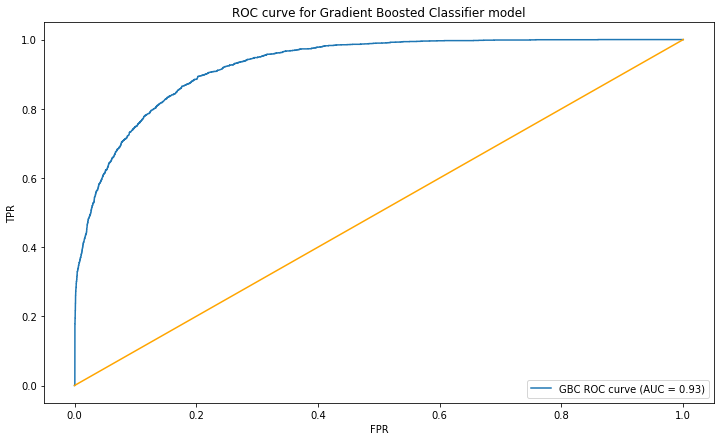

In [138]:
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y_test["income_bracket"],  tuned_gbc["test_results"]["over_50_prob"])

plt.figure(figsize = (12, 7))

plt.plot(fpr, tpr, label = "GBC ROC curve (AUC = %0.2f)" % tuned_gbc["test_auc"])
plt.plot([0, 1], [0, 1], color = "orange")
plt.legend(loc = 4)
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ROC curve for Gradient Boosted Classifier model")
plt.show()

In [137]:
import os
os.getcwd()

'C:\\Users\\Mark\\Machine Learning 5'